In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df = pd.read_csv('geo-reviews-dataset-2023.csv')
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  500000 non-null  object 
 1   name_ru  499030 non-null  object 
 2   rating   500000 non-null  float64
 3   rubrics  500000 non-null  object 
 4   text     500000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.1+ MB


## Cleaning

In [17]:
df[df['name_ru'].isna()]

,address,name_ru,rating,rubrics,text
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5.0,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе..."
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Гостиница действительно хорошая, удобно распол..."
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,Был здесь на кулинарном мастер-классе. Место а...
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Тихое место, в выходные возможно и шумно так к..."
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к..."
...,...,...,...,...,...
498536,"Республика Башкортостан, Уфа, улица Менделеева...",NaN,5.0,"Скалодром;Спортивный клуб, секция",Были с детьми на 8 марта. Приехали специально ...
498688,"Москва, Юго-Восточный административный округ, ...",NaN,5.0,Изготовление памятников и надгробий;Изделия из...,"Отличное качество материала, прекрасное исполн..."
498913,"Самарская область, Волжский район, жилой район...",NaN,1.0,Магазин цветов;Копировальный центр;Товары для ...,"Цен на цветы которые находятся на витрине нет,..."
499006,"Волгоград, улица Гроссмана, 6",NaN,5.0,Салон красоты,Квалифицированные мастера. Работу выполняют с ...


In [18]:
df['name_ru'] = df['name_ru'].fillna('нет')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  500000 non-null  object 
 1   name_ru  500000 non-null  object 
 2   rating   500000 non-null  float64
 3   rubrics  500000 non-null  object 
 4   text     500000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.1+ MB


In [19]:
# проверка маленьких текстов отзывов
sum([1 if len(text) < 10 else 0 for text in df['text']])

38

In [20]:
df = df[df['text'].str.len() >= 10]
df.shape

(499962, 5)

In [8]:
df['rating'].value_counts()

rating
5.0    390478
4.0     41159
1.0     34351
3.0     21686
2.0     12088
0.0       200
Name: count, dtype: int64

In [9]:
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

def clean_address(address):
    # Замена слешей, не связанных с цифрами, на пробелы
    address = re.sub(r"(?<!\d)/|(?!\d)/", " ", address)
    # Удаление лишних пробелов
    address = re.sub(r"\s+", " ", address)

    return address

def clean_text(text):
    # Замена переносов строк пробелами
    text = re.sub(r"[\\n\\r]+", " ", text)

    # Удалить HTML-теги
    text = re.sub(r"<[^>]+>", "", text)

    # Удалить специальные символы
    text = re.sub(r"[^\w\s,.!?()]+", "", text)

    return text

def text_preprocessing(data):
    """
    Предобработка с помощью NLTK
    """
    # Привести к нижнему регистру и токенизировать
    tokens = nltk.word_tokenize(data.lower())

    # Исключить стоп-слова 
    # лемматизация 
    return [lemmatizer.lemmatize(t) for t in tokens
            if t not in stop_words and len(t) > 2 and not t.isdigit()]

In [10]:
df_cleaned = df.copy()

df_cleaned = df_cleaned[df_cleaned['rating'] > 0]

df_cleaned['text'] = df_cleaned['text'].apply(clean_text)
df_cleaned['address'] = df_cleaned['address'].apply(clean_address)
df_cleaned['name_ru'] = df_cleaned['name_ru'].str.strip()
df_cleaned['rubrics'] = df_cleaned['rubrics'].str.strip().str.lower()
df_cleaned['text_len'] = df_cleaned["text"].apply(lambda x: len(x))
df_cleaned['tokens'] = df_cleaned['text'].apply(text_preprocessing)
df_cleaned['cleaned_text'] = df_cleaned['tokens'].str.join(' ')

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499762 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   address       499762 non-null  object 
 1   name_ru       499762 non-null  object 
 2   rating        499762 non-null  float64
 3   rubrics       499762 non-null  object 
 4   text          499762 non-null  object 
 5   text_len      499762 non-null  int64  
 6   tokens        499762 non-null  object 
 7   cleaned_text  499762 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 34.3+ MB


## Statistics

In [12]:
word_counts = df_cleaned["text"].apply(lambda x: len(x.split()))

print("Базовая статистика:")
print(f"Среднее количество слов: {np.mean(word_counts):.2f}")
print(f"Стандартное отклонение: {np.std(word_counts):.2f}")
print(f"Минимальное количество слов: {np.min(word_counts)}")
print(f"Максимальное количество слов: {np.max(word_counts)}")
print(f"Медиана количества слов: {np.median(word_counts)}")

Базовая статистика:
Среднее количество слов: 43.79
Стандартное отклонение: 44.66
Минимальное количество слов: 1
Максимальное количество слов: 3019
Медиана количества слов: 30.0


In [19]:
rubrics = df_cleaned['rubrics'].value_counts()
rubrics

rubrics
гостиница                                                          42217
ресторан                                                           14612
кафе                                                               12359
супермаркет                                                         8890
магазин продуктов                                                   5287
                                                                   ...  
мука и крупы;продукты питания оптом;магазин продуктов                  1
технические и медицинские газы;сварочные работы;кованые изделия        1
ресторан;бар, паб;кафе;столовая                                        1
буровые работы;нефтегазовая компания                                   1
школа танцев;студия йоги;стретчинг                                     1
Name: count, Length: 31783, dtype: int64

In [20]:
ones = rubrics[rubrics == 1]
len(ones)

15804

In [21]:
total_reviews = df_cleaned.shape[0]

top_rubrics = rubrics.head(10)

print(f"{0}. С одним отзывом - {len(ones)} рубрик ({((len(ones) / total_reviews) * 100):.2f}%)\n")

for i, r in enumerate(zip(top_rubrics.index, top_rubrics)):
    print(f"{i + 1}. {r[0]} - {r[1]} отзывов ({((r[1] / total_reviews) * 100):.2f}%)")

0. С одним отзывом - 15804 рубрик (3.16%)

1. гостиница - 42217 отзывов (8.45%)
2. ресторан - 14612 отзывов (2.92%)
3. кафе - 12359 отзывов (2.47%)
4. супермаркет - 8890 отзывов (1.78%)
5. магазин продуктов - 5287 отзывов (1.06%)
6. музей - 5000 отзывов (1.00%)
7. быстрое питание - 4902 отзывов (0.98%)
8. ресторан;кафе - 4550 отзывов (0.91%)
9. супермаркет;магазин продуктов - 4538 отзывов (0.91%)
10. пункт выдачи - 4315 отзывов (0.86%)


In [22]:
sum(top_rubrics.values)

106670

In [25]:
IMG_PATH = Path('./img/')
os.makedirs(Path(IMG_PATH), exist_ok=True)

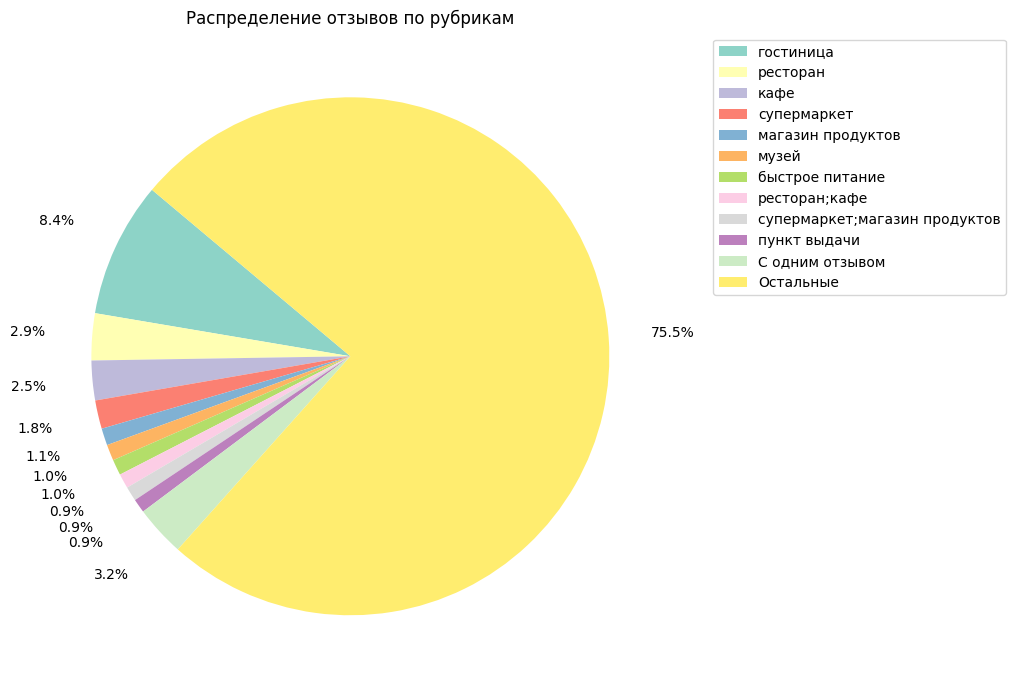

In [26]:
rubrics_labels = top_rubrics.index.to_list() + ['С одним отзывом', 'Остальные']
rubrics_counts = top_rubrics.values.tolist() + [len(ones), total_reviews - sum(top_rubrics.values) - len(ones)]

plt.figure(figsize=(10, 7))
plt.pie(rubrics_counts, autopct='%1.1f%%', pctdistance=1.25, startangle=140, colors=plt.cm.Set3.colors)

plt.title('Распределение отзывов по рубрикам')
plt.legend(rubrics_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(IMG_PATH.joinpath('rubrics_pie_chart.png'))
plt.show()

In [27]:
ratings = df_cleaned['rating'].value_counts()
ratings

rating
5.0    390478
4.0     41159
1.0     34351
3.0     21686
2.0     12088
Name: count, dtype: int64

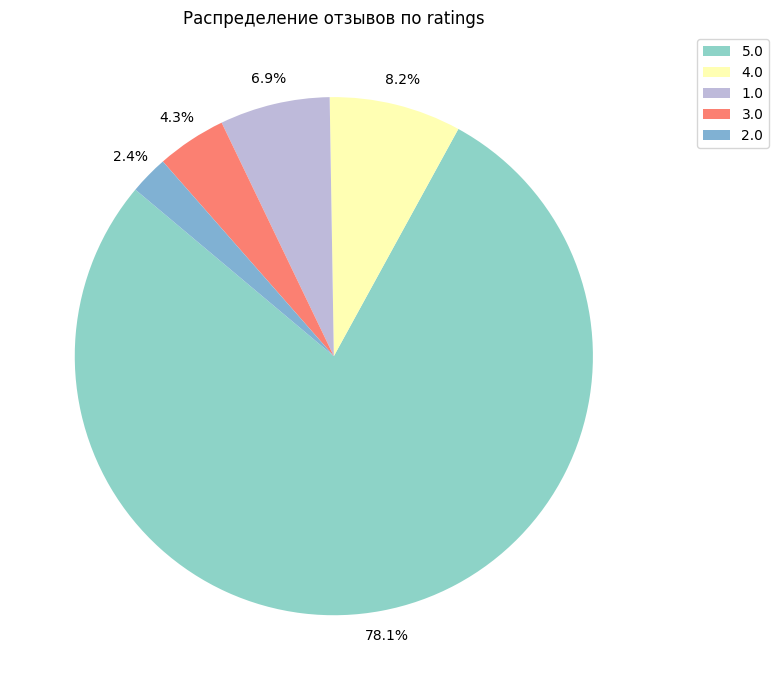

In [28]:
plt.figure(figsize=(10, 7))
plt.pie(ratings, autopct='%1.1f%%', pctdistance=1.1, startangle=140, colors=plt.cm.Set3.colors)

plt.title('Распределение отзывов по ratings')
plt.legend(ratings.index, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(IMG_PATH.joinpath('ratings_pie_chart.png'))
plt.show()

In [29]:
others = ones.index.to_list() + top_rubrics.index.to_list()
  
def filtered_texts(rubric):
    if rubric == 10: # 'С одним отзывом'
        return df_cleaned[df_cleaned['rubrics'].isin(ones.index)]
    elif rubric == 11: # 'Остальные'
        return df_cleaned[~df_cleaned['rubrics'].isin(others)]
    else:
        return df_cleaned[df_cleaned['rubrics'] == rubrics_labels[rubric]]
    
rubric_dict = {rubrics_label: filtered_texts(rubric) for rubric, rubrics_label in enumerate(rubrics_labels)}
rubric_dict

{'гостиница':                                                   address  \
 16      Алтайский край, особая экономическая зона тури...   
 48      Севастополь, Балаклавский муниципальный округ,...   
 77      Свердловская область, Нижний Тагил, улица Окун...   
 105         Ростов-на-Дону, проспект 40-летия Победы, 198   
 106         Ростов-на-Дону, проспект 40-летия Победы, 198   
 ...                                                   ...   
 499956                           Тула, Советская улица, 3   
 499957                           Тула, Советская улица, 3   
 499958                           Тула, Советская улица, 3   
 499959                           Тула, Советская улица, 3   
 499960                           Тула, Советская улица, 3   
 
                        name_ru  rating    rubrics  \
 16            Бирюзовая Катунь     5.0  гостиница   
 48                      Баунти     5.0  гостиница   
 77                  Парк Отель     5.0  гостиница   
 105                   Ме

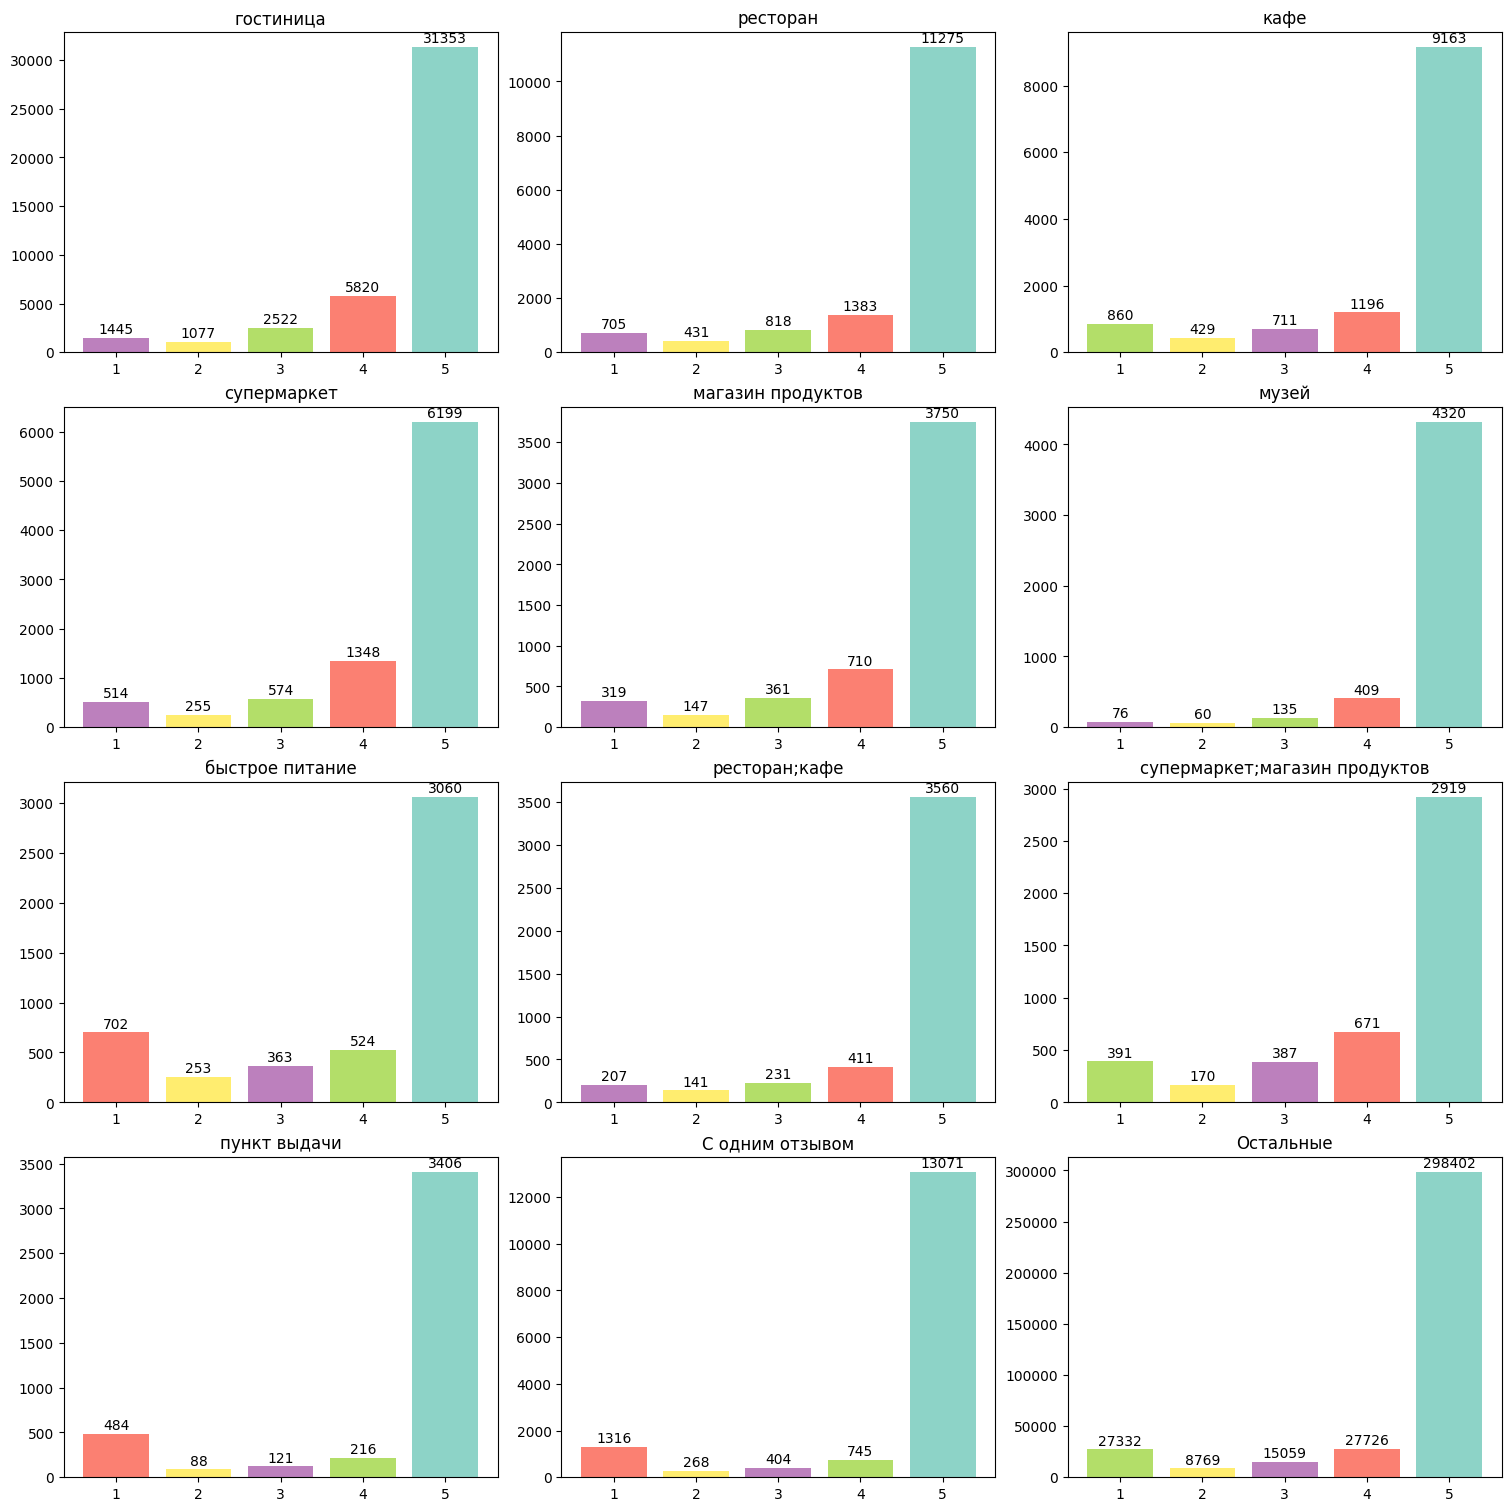

In [33]:
bar_colors = plt.cm.Set3(np.linspace(0, 1, 5))

def ratings_rubrics_plot(ax, rubric):
    filtered = rubric_dict[rubric]
    res = filtered['rating'].value_counts()
    rects = ax.bar(res.index, res, width=0.8, label=res.index, color=bar_colors)
    ax.bar_label(rects, padding=1)
    ax.set_title(rubric)

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), layout='constrained')

for i, ax in enumerate(axs.flat):
    ratings_rubrics_plot(ax, rubrics_labels[i])

plt.savefig(IMG_PATH.joinpath('ratings_rubrics.png'))


## Texts, words

In [34]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=1,
    max_df=0.95,
    ngram_range=(1, 2),
)
tfidf_matrix = vectorizer.fit_transform(df_cleaned['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()
raw_frequencies = np.array(tfidf_matrix.tocsr().sum(axis=0)).flatten()

In [35]:
word_scores = [
    (word, float(freq))
    for word, freq in zip(feature_names, raw_frequencies)
    if freq > 0
]

max_score = max(score for _, score in word_scores)
word_scores = [(word, score / max_score) for word, score in word_scores]

word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)[:100]
word_scores[:5]

[('очень', 1.0),
 ('персонал', 0.4686272594724097),
 ('это', 0.456563111690138),
 ('место', 0.4414421305165987),
 ('спасибо', 0.42396712448321966)]

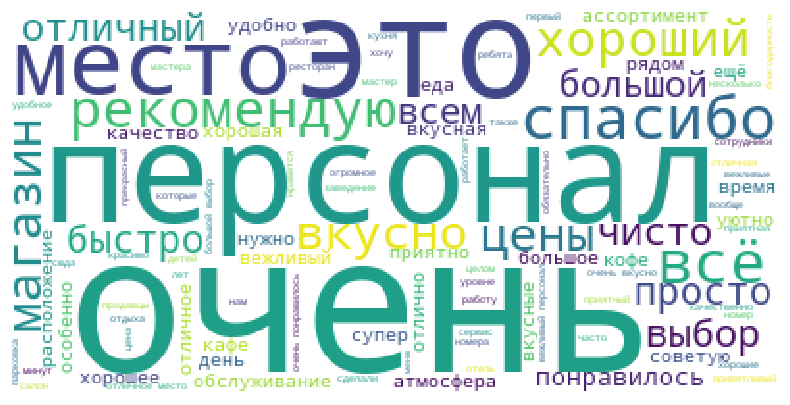

Text(0.5, 1.0, 'nearest')

In [36]:
word_freq = {word: score for word, score in word_scores}
wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.savefig(IMG_PATH.joinpath('wordcloud.png'))
plt.show()

ax.set_title(f'nearest', fontsize=12, color='red', weight='bold', pad=20)

In [37]:
rubrics_scores = {}

for rubric, rubrics_df in rubric_dict.items():
    tfidf_matrix = vectorizer.fit_transform(rubrics_df['cleaned_text'])
    feature_names = vectorizer.get_feature_names_out()
    raw_frequencies = np.array(tfidf_matrix.tocsr().sum(axis=0)).flatten()
    word_scores = [
        (word, float(freq))
        for word, freq in zip(feature_names, raw_frequencies)
        if freq > 0
    ]

    max_score = max(score for _, score in word_scores)
    word_scores = [(word, score / max_score) for word, score in word_scores]

    word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]

    rubrics_scores[rubric] = word_scores

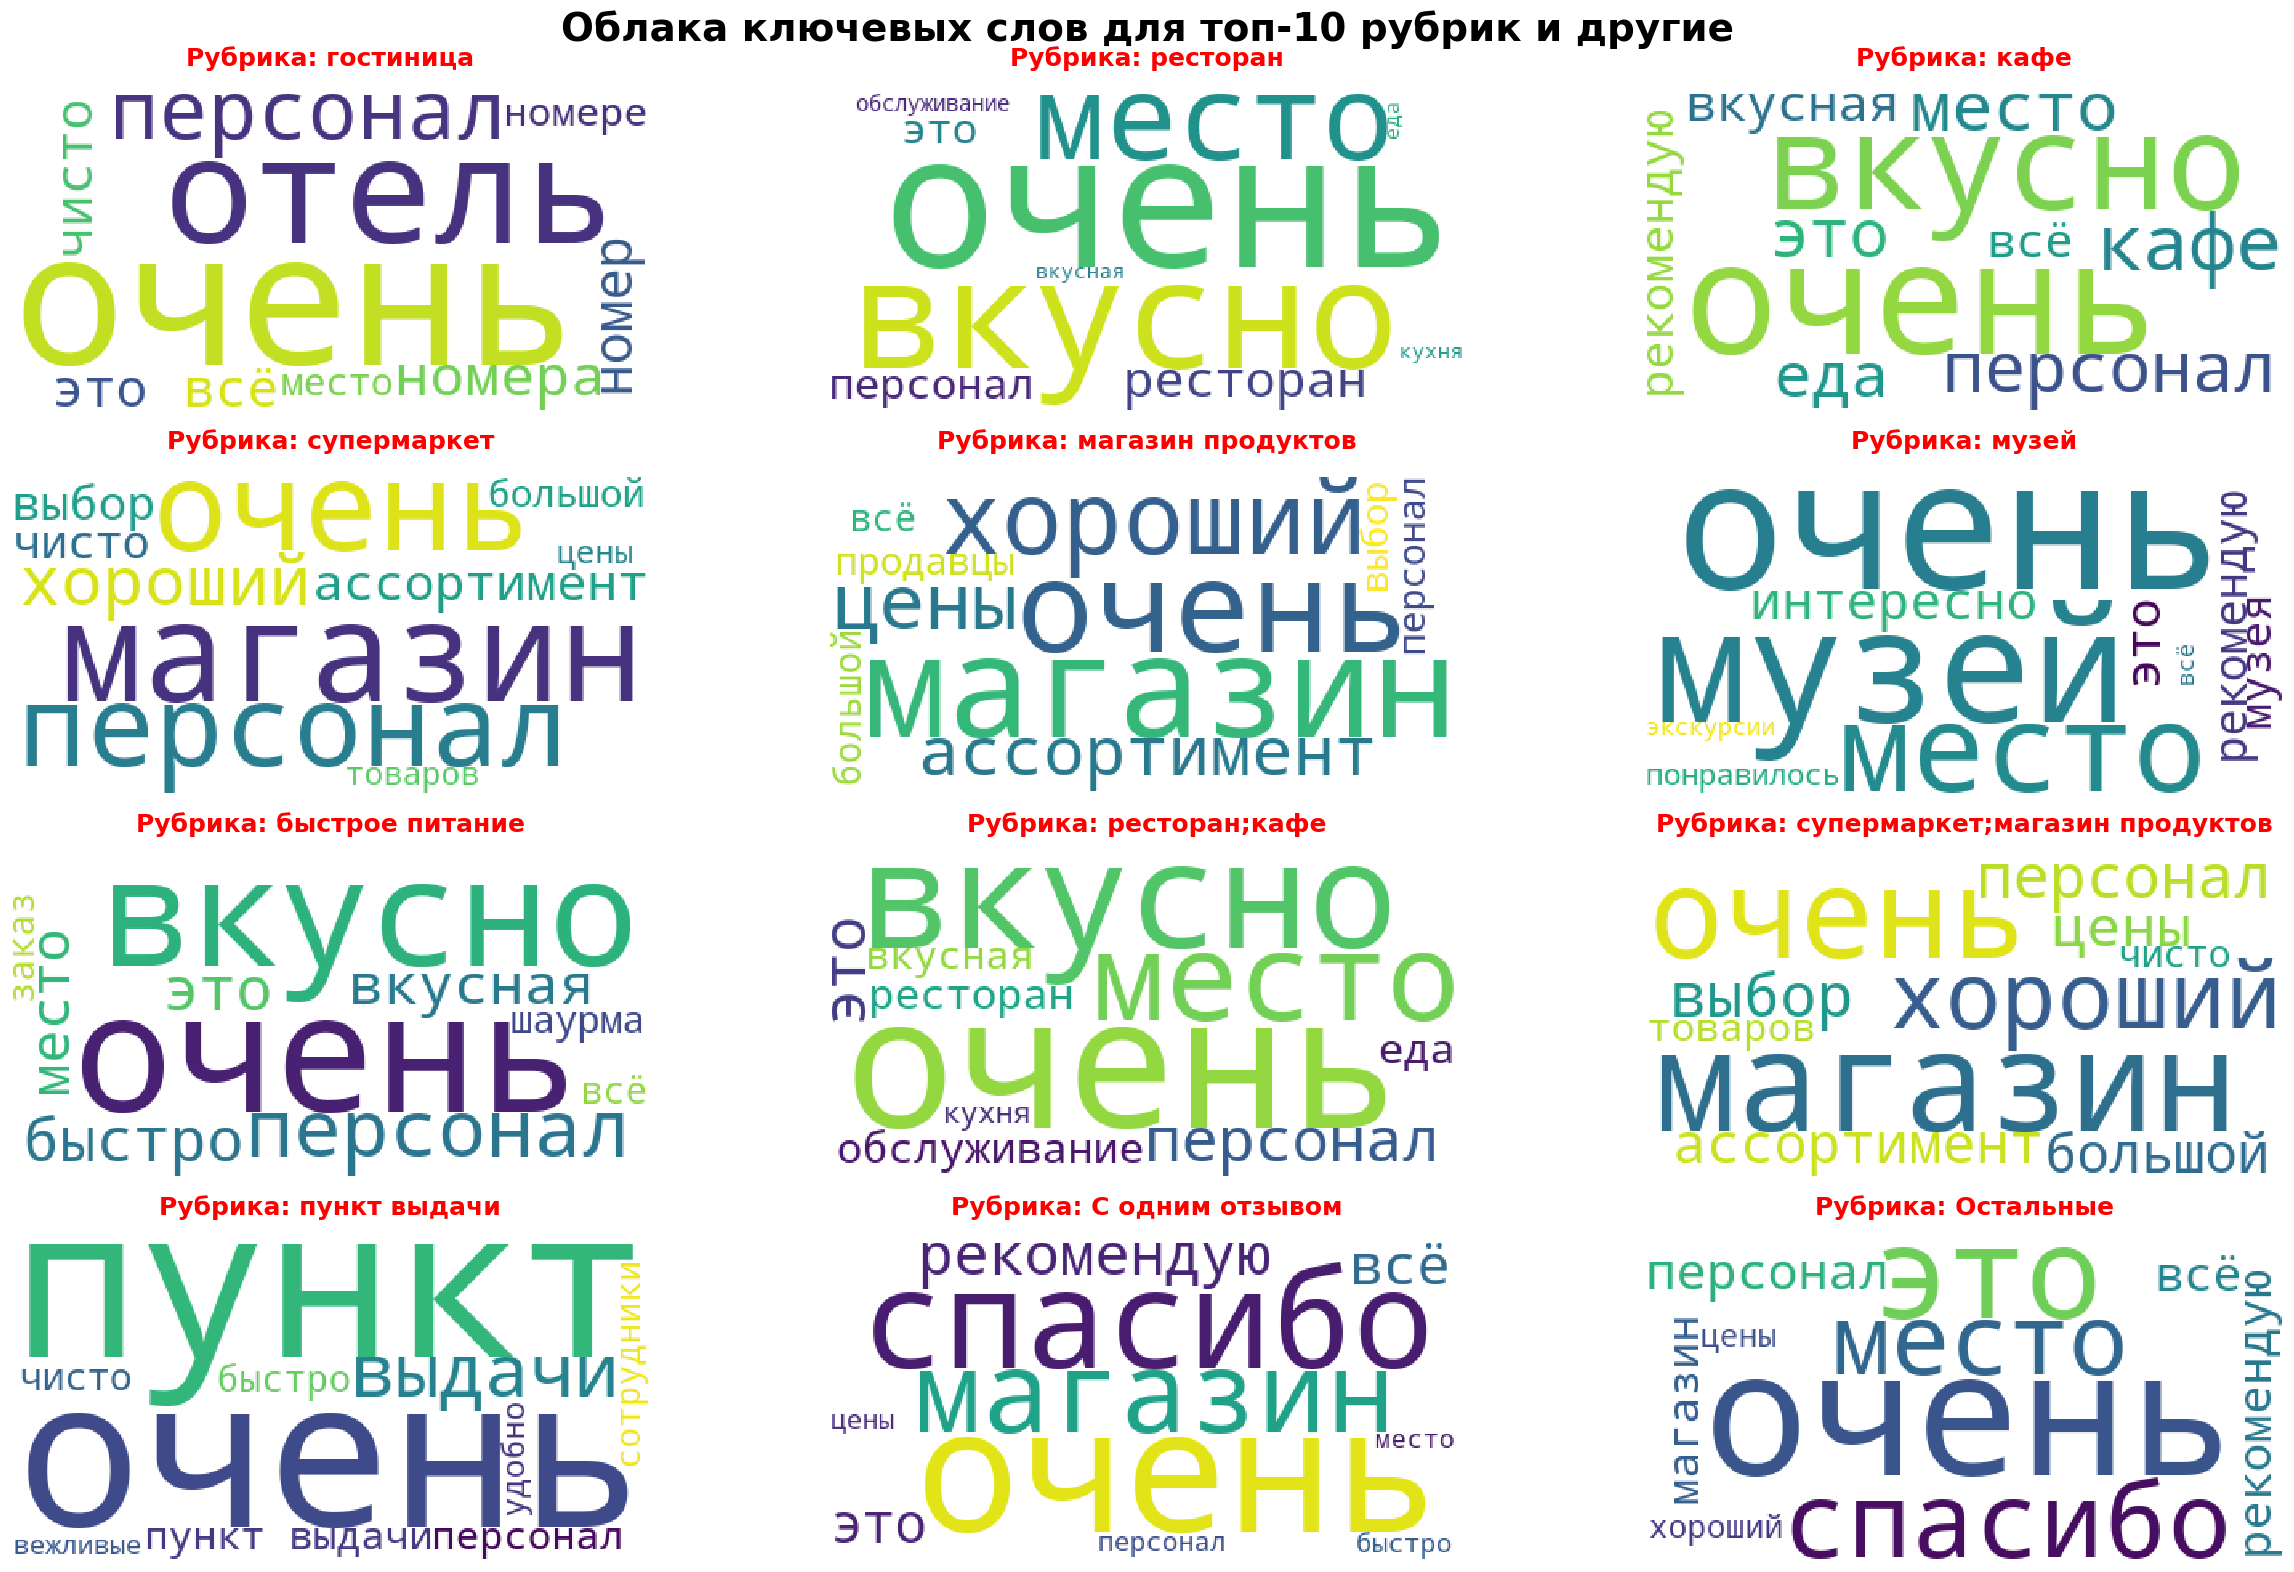

In [39]:
n_cols = 3
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 16))
fig.suptitle('Облака ключевых слов для топ-10 рубрик и другие', fontsize=28, color='black', weight='bold')

for i, (rubric, rubrics_score) in enumerate(rubrics_scores.items()):
    word_freq = {word: score for word, score in rubrics_score}
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)

    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(wordcloud, interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'Рубрика: {rubric}', fontsize=18, color='red', weight='bold', pad=20)


for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])


plt.tight_layout()
plt.savefig(IMG_PATH.joinpath('combined_wordcloud.png'))
plt.show()

## Исследовать корреляцию между длиной отзыва и его оценкой.

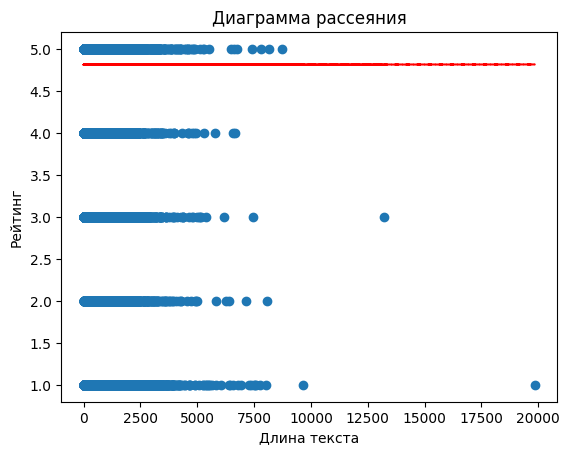

In [40]:
# Построение диаграммы рассеяния
plt.scatter(df_cleaned['text_len'], df_cleaned['rating'])
plt.title('Диаграмма рассеяния')
plt.xlabel('Длина текста')
plt.ylabel('Рейтинг')

# Добавление линии тренда (линейная регрессия)
# Для этого сначала рассчитаем коэффициенты регрессии с помощью numpy
m, b = np.polyfit(df_cleaned['text_len'], df_cleaned['rating'], 1)
plt.plot(df_cleaned['text_len'], m * df_cleaned['rating'] + b, color='red', linestyle='--')
plt.savefig(IMG_PATH.joinpath('xorr_text_len_rating.png'))
plt.show()